# Training xG model with Python

## Loading data

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('./data/raw_data.csv', index_col = 0)
df.head()

,league,id,minute,result,X,Y,player,h_a,player_id,situation,season,shotType,match_id,home_team,away_team,home_goals,away_goals,date,player_assisted,lastAction
1,Ligue_1,425095,7,MissedShots,0.964,0.654,Myron Boadu,h,9612,OpenPlay,2021,LeftFoot,17822,Monaco,Nantes,1,1,2021-08-06 19:00:00,NaN,BallRecovery
2,Ligue_1,425098,13,Goal,0.925,0.431,Gelson Martins,h,7012,OpenPlay,2021,RightFoot,17822,Monaco,Nantes,1,1,2021-08-06 19:00:00,Caio Henrique,Throughball
3,Ligue_1,425100,24,BlockedShot,0.785,0.388,Kevin Volland,h,83,OpenPlay,2021,LeftFoot,17822,Monaco,Nantes,1,1,2021-08-06 19:00:00,NaN,None
4,Ligue_1,425101,24,MissedShots,0.761,0.525,Jean Lucas,h,7687,OpenPlay,2021,RightFoot,17822,Monaco,Nantes,1,1,2021-08-06 19:00:00,NaN,Rebound
5,Ligue_1,425102,30,MissedShots,0.936,0.415,Kevin Volland,h,83,FromCorner,2021,Head,17822,Monaco,Nantes,1,1,2021-08-06 19:00:00,Jean Lucas,Aerial


## First step preprocessing

In [ ]:
df = df[df.result != "OwnGoal"]

In [ ]:
df['status'] = np.where(df.result == "Goal", 1, 0)

In [ ]:
df = df.drop('result', axis = 1)

Column `lastAction` has value `KeeperSweeper` only for two observations - it causes some problems next in train-test-split and label encoding, so I'll delete these observations.

In [ ]:
df[df.lastAction == 'KeeperSweeper']

,league,id,minute,X,Y,player,h_a,player_id,situation,season,shotType,match_id,home_team,away_team,home_goals,away_goals,date,player_assisted,lastAction,status
131445,EPL,54081,33,0.736,0.565,Philippe Coutinho,h,488,OpenPlay,2015,RightFoot,238,Liverpool,West Bromwich Albion,2,2,2015-12-13 20:00:00,Emre Can,KeeperSweeper,0
200119,La_liga,84192,61,0.817,0.533,Pedro Mosquera,h,2320,FromCorner,2015,RightFoot,1400,Deportivo La Coruna,Real Sociedad,0,0,2015-08-22 20:30:00,Celso Borges,KeeperSweeper,0


In [ ]:
df = df[df.lastAction != 'KeeperSweeper']

In [ ]:
X = df.drop('status', axis=1)
Y = df['status']

In [ ]:
df.to_csv('./data/data.csv')

In [ ]:
del df

## Split data into training and test set

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 123, stratify = Y)

## Oversampling minority class

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

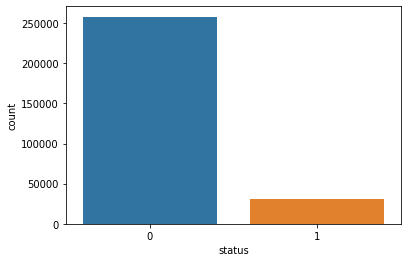

In [ ]:
sns.countplot(x = y_train)
plt.show()

In [ ]:
# !pip install imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
sampler = RandomOverSampler(random_state = 123)
X_train_oversampled, y_train_oversampled = sampler.fit_resample(X_train, y_train)

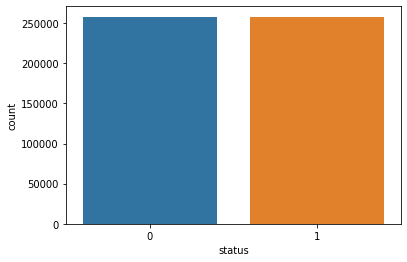

In [ ]:
sns.countplot(x = y_train_oversampled)
plt.show()

## Preprocessing

In [ ]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import LabelEncoder

In [ ]:
from scripts.preprocess import Transformer

In [ ]:
tr = Transformer()
tr.fit(X_train_oversampled, y_train_oversampled)

Transformer()

In [ ]:
X_train_oversampled = tr.transform(X_train_oversampled)

In [ ]:
X_test = tr.transform(X_test)

In [ ]:
X_train_oversampled.head()

,minute,h_a,situation,shotType,lastAction,distanceToGoal,angleToGoal
0,69,1,4,3,25,5.632020,54.961854
1,49,1,2,0,10,7.983891,36.232931
2,5,1,1,3,22,21.912966,16.855384
3,82,1,2,3,36,23.001094,16.285422
4,43,1,2,1,25,17.586309,16.905345


Saving preprocessed datasets

In [ ]:
pd.concat([X_train_oversampled, y_train_oversampled], axis=1).to_csv('./data/dataset_train_oversampled.csv')

In [ ]:
pd.concat([X_test, y_test], axis=1).to_csv('./data/dataset_test.csv')

## Training a model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_oversampled, y_train_oversampled)

RandomForestClassifier()

In [ ]:
import pickle

with open(r"./model/model.pickle", "wb") as output_file:
    pickle.dump(rf, output_file)

## Evaluating the model

In [ ]:
X_train_transformed_not_oversampled = tr.transform(X_train)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [ ]:
def calculate_metrics(model, X, y):
    y_hat = model.predict(X)
    y_hat_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_hat)
    balanced_accuracy = balanced_accuracy_score(y, y_hat)
    f1 = f1_score(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    roc_auc = roc_auc_score(y, y_hat_proba)

    return pd.DataFrame({
        'accuracy' : accuracy,
        'balanced_accuracy' : balanced_accuracy,
        'f1' : f1,
        'precision' : precision,
        'recall' : recall,
        'roc_auc' : roc_auc
    }, index=[0])

In [ ]:
calculate_metrics(rf, X_train_transformed_not_oversampled, y_train)

,accuracy,balanced_accuracy,f1,precision,recall,roc_auc
0,0.997116,0.998385,0.986701,0.973751,1.0,0.999865


In [ ]:
calculate_metrics(rf, X_test, y_test)

,accuracy,balanced_accuracy,f1,precision,recall,roc_auc
0,0.88454,0.617731,0.340271,0.437793,0.278281,0.757715


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3965177e-3b24-40f1-9445-2feb56564f30' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>